In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import numpy as np 
import matplotlib.pyplot as plt 
import data
import gpt 
from tqdm import tqdm, trange
import json 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
if device == 'cuda':
  print(torch.cuda.get_device_name()) 
else: 
  print(device) 

with open('config.json', 'r') as file: 
  config = json.load(file)

lr = config['lr']
bs = config['batch_size']

vocab_size, encode = data._init_data() 

NVIDIA GeForce RTX 3090


In [2]:
model = gpt.gpt_model(vocab_size=vocab_size).to(device) 
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters.')
model.load_state_dict(torch.load('models/adaptive_span_final_23k.pth'))

59.968665 M parameters.


<All keys matched successfully>

In [55]:
test_in = torch.tensor(data.encode('Chandler Bing: How is ')).unsqueeze(0).to(device)

with torch.no_grad(): 
	tok_emb = model.token_embedding(test_in)
	pos_emb = model.position_embedding(torch.arange(test_in.size(1), device=device))
	x = tok_emb + pos_emb 
	x = model.blocks[0].ln1(x) 
	k = model.blocks[0].sa.heads[0].key(x)
	q = model.blocks[0].sa.heads[1].query(x) 
	weight = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
	weight = weight.masked_fill(model.blocks[0].sa.heads[0].tril[:x.size(1), :x.size(1)] == 0, float('-inf'))
	weight = F.softmax(weight, dim=-1)
	weight2 = model.blocks[0].sa.heads[0].adaptive_span(weight)

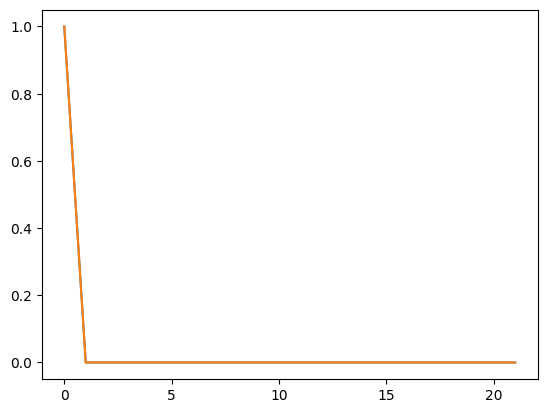

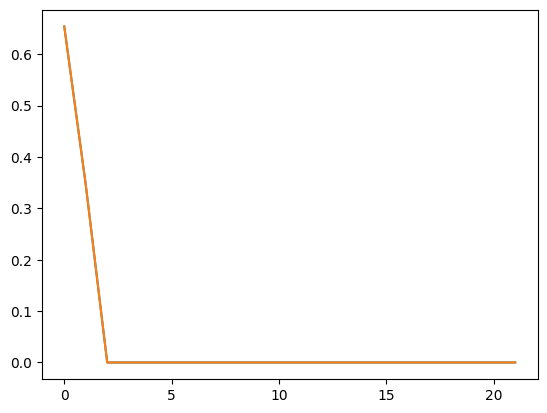

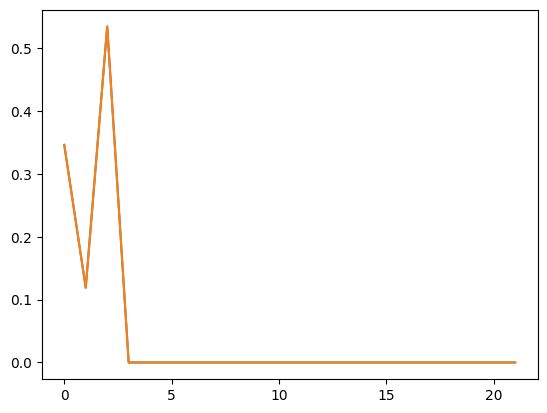

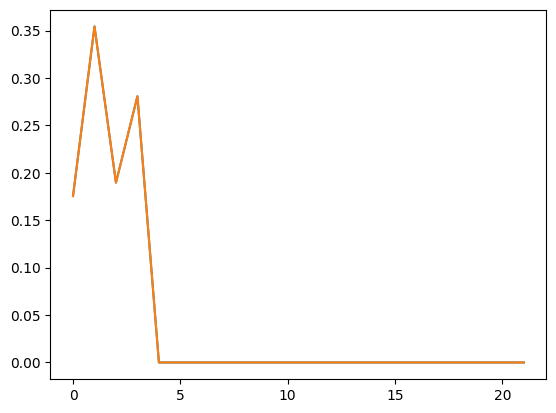

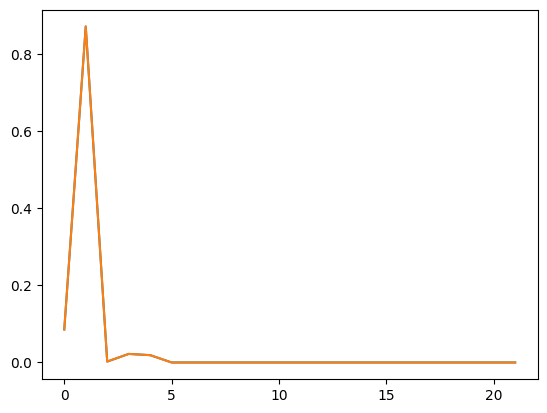

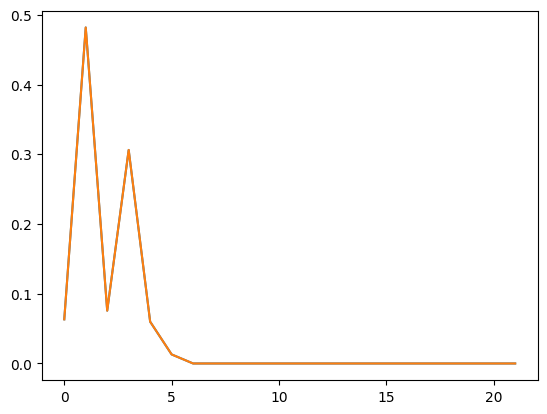

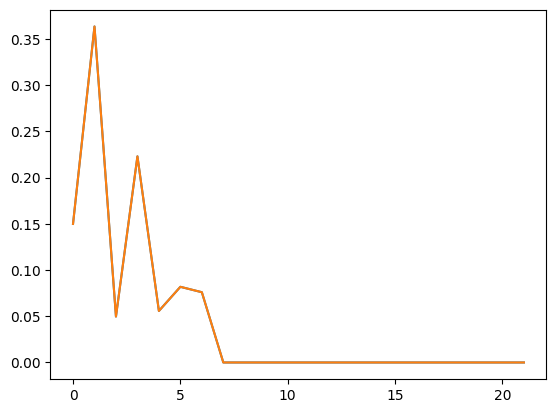

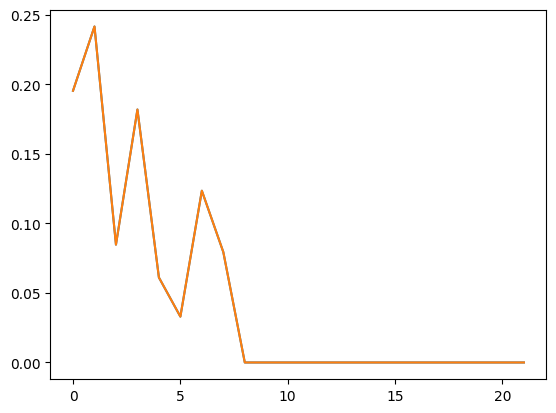

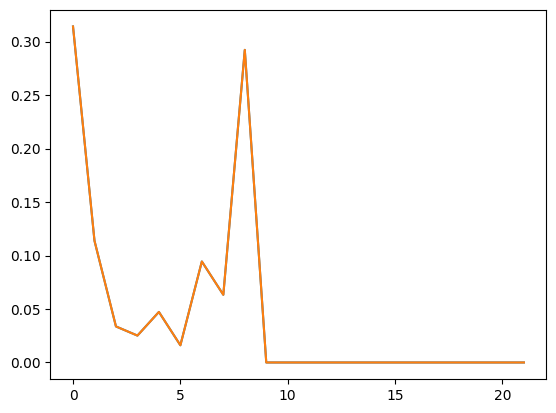

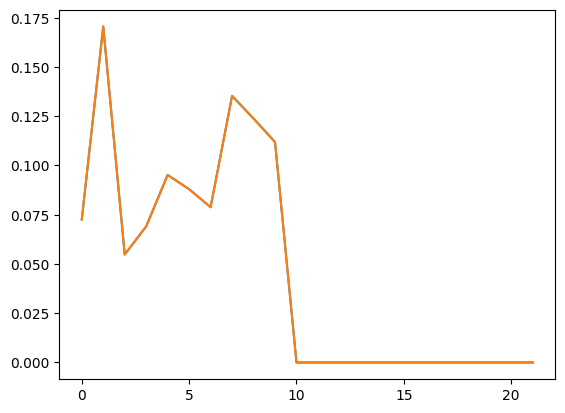

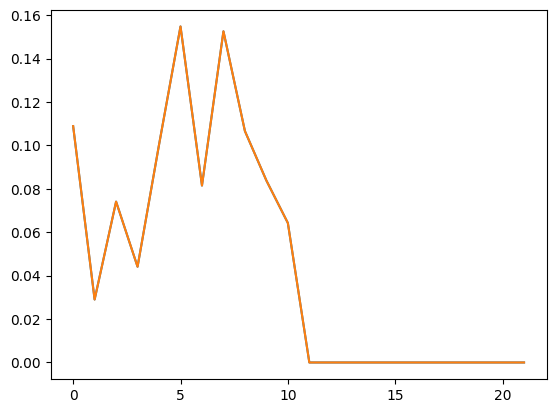

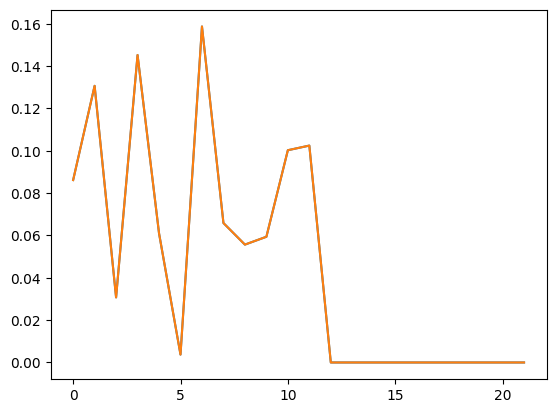

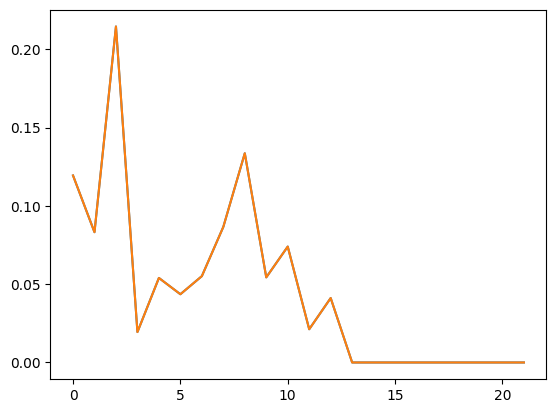

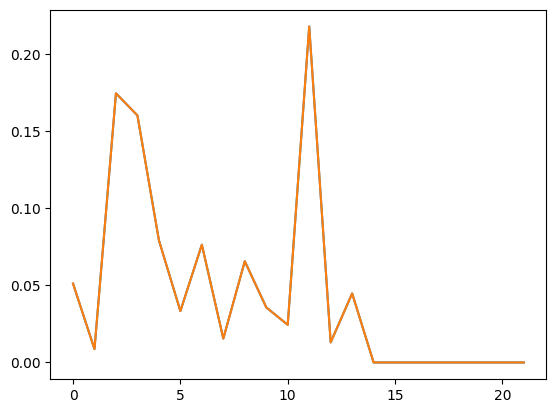

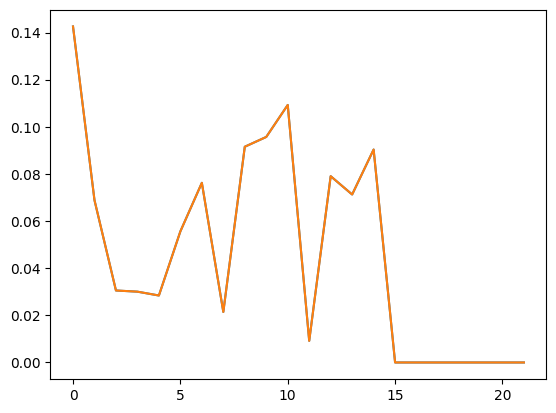

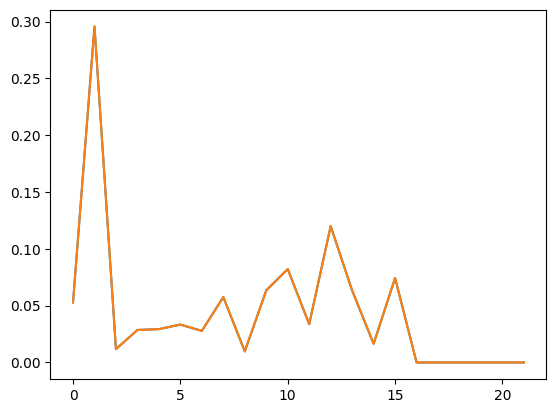

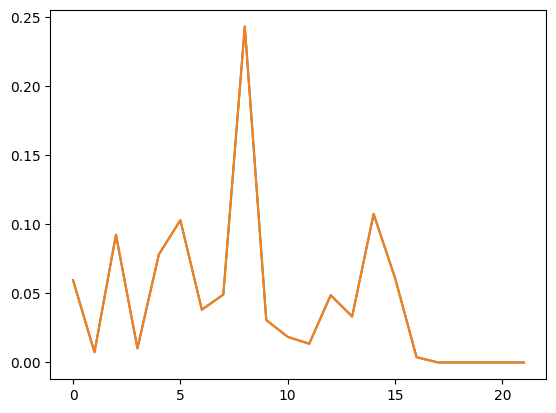

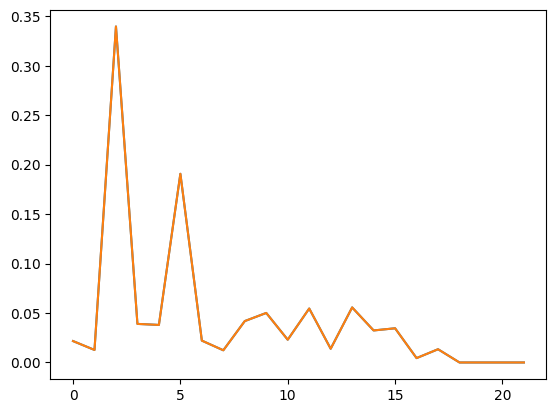

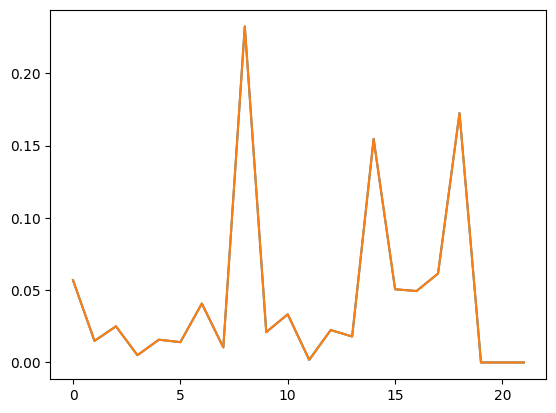

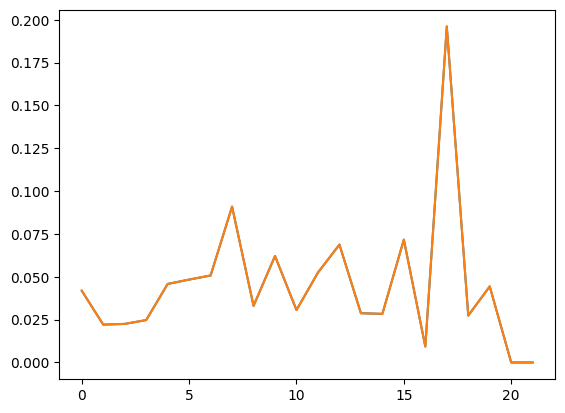

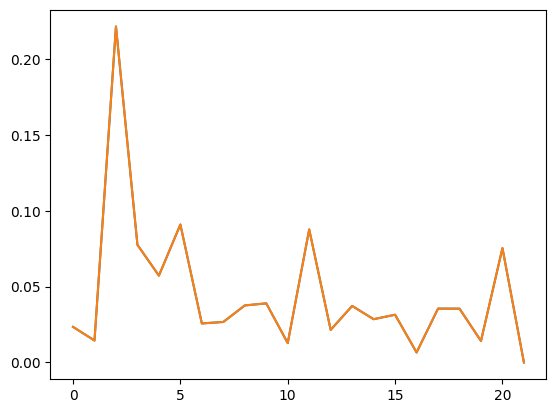

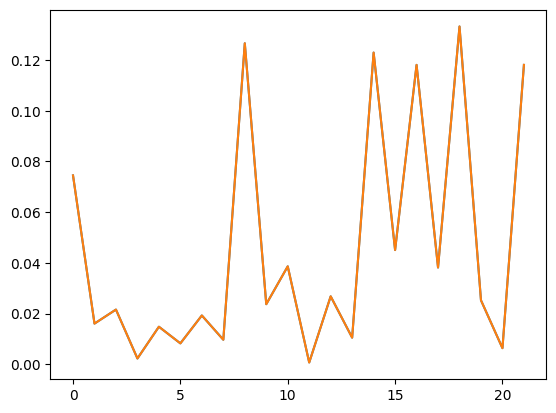

In [59]:
for idx, i in enumerate(weight[0].detach().cpu()): 
	plt.plot(i)
	plt.plot(weight2[0][idx].detach().cpu())
	plt.show()

In [65]:
(weight.view(-1) - weight2.view(-1)).mean()

tensor(-4.1010e-10, device='cuda:0')

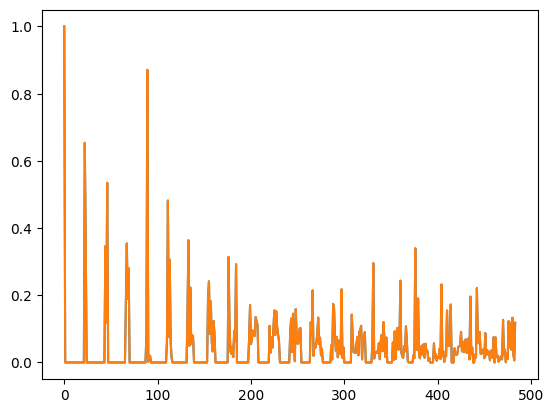

In [60]:
plt.plot(weight.detach().cpu().view(-1))
plt.plot(weight2.detach().cpu().view(-1))

In [24]:
model.blocks[0].sa.heads[0]

attention_head(
  (key): Linear(in_features=768, out_features=96, bias=False)
  (query): Linear(in_features=768, out_features=96, bias=False)
  (value): Linear(in_features=768, out_features=96, bias=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (adaptive_span): adaptive_span()
)

NameError: name 'mask' is not defined

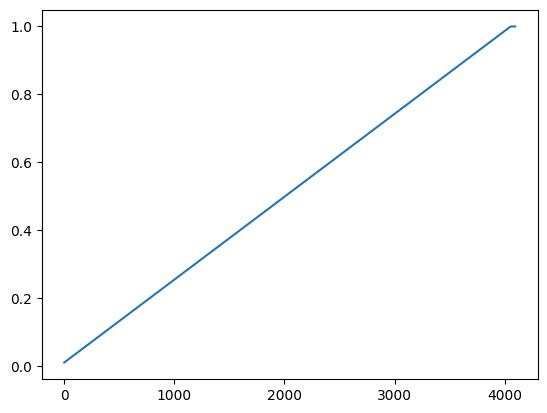

In [82]:
mask = i.adaptive_span.mask_template.detach().cpu() + i.adaptive_span.current_val.detach().cpu() * i.adaptive_span.max_size
mask = (mask / i.adaptive_span.ramp_size + 1).clamp(0, 1)
plt.plot(mask[0, 0])

In [32]:
i.adaptive_span.mask_template

tensor([-4.0950e+03, -4.0940e+03, -4.0930e+03,  ..., -2.0000e+00,
        -1.0000e+00,  0.0000e+00], device='cuda:0')

In [39]:
i.adaptive_span.max_size

4096

In [38]:
i.adaptive_span.current_val * i.adaptive_span.max_size

tensor([[[42.2026]]], device='cuda:0', grad_fn=<MulBackward0>)

In [48]:
mask.shape

torch.Size([1, 1, 4096])

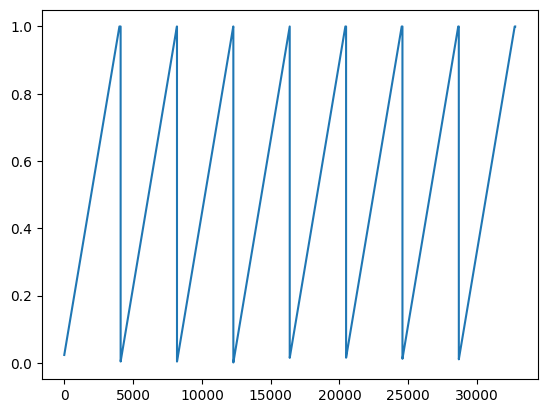

In [81]:
masks = list()
for i in model.blocks[0].sa.heads: 
  mask = i.adaptive_span.mask_template.detach().cpu() + i.adaptive_span.current_val.detach().cpu() * i.adaptive_span.max_size
  mask = (mask / i.adaptive_span.ramp_size + 1).clamp(0, 1)
  masks.append(mask)
plt.plot(torch.stack(masks).view(-1))

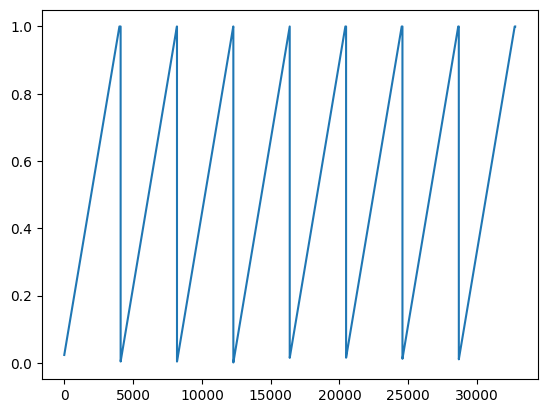

In [71]:
plt.plot(torch.stack(masks).view(-1))